In [1]:
import matplotlib.pyplot as plt
from ipywidgets import *
import numpy as np
import sys
import taurex.log
from taurex.cache import OpacityCache,CIACache
import pandas as pd
import corner

taurex.log.disableLogging()

In [2]:
path_to_data = '../../data'
OpacityCache().clear_cache()
OpacityCache().set_opacity_path(f"{path_to_data}/atmosphere/xsecs")
CIACache().set_cia_path(f"{path_to_data}/atmosphere/cia/hitran")

## Creating transmission spectrum

We define the star and planet models to create a transmission spectrum.

In [4]:
from taurex.temperature import Isothermal
isothermal = Isothermal(T=1200.0)

from taurex.planet import Planet
planet = Planet(planet_radius=1.0,planet_mass=0.8)

from taurex.stellar import BlackbodyStar

star = BlackbodyStar(temperature=5500,radius=1.05, metallicity=0.14)

from taurex.chemistry import TaurexChemistry
chemistry = TaurexChemistry(fill_gases=['H2','He'],ratio=0.17)

from taurex.chemistry import ConstantGas

chemistry.addGas(ConstantGas('H2O',mix_ratio=1e-6))
chemistry.addGas(ConstantGas('CO2',mix_ratio=1e-6))
chemistry.addGas(ConstantGas('CO',mix_ratio=1e-6))
chemistry.addGas(ConstantGas('Na',mix_ratio=1e-6))
chemistry.addGas(ConstantGas('K',mix_ratio=1e-6))

In [5]:
from taurex.model import TransmissionModel
tm = TransmissionModel(planet=planet,
                       temperature_profile=isothermal,
                       chemistry=chemistry,
                       star=star,
                        atm_min_pressure=1e-0,
                       atm_max_pressure=1e6,
                       nlayers=30)

from taurex.contributions import AbsorptionContribution
tm.add_contribution(AbsorptionContribution())

from taurex.contributions import CIAContribution
tm.add_contribution(CIAContribution(cia_pairs=['H2-H2','H2-He']))

from taurex.contributions import RayleighContribution
tm.add_contribution(RayleighContribution())

tm.build()
res = tm.model()

## Importing real transmission spectrum

We import the pruned spectrum from the real JWST observation of WASP-96b.

In [6]:
from taurex.data.spectrum.observed import ObservedSpectrum
obs = ObservedSpectrum(f'WASP-96b_pruned_spectrum.dat')

## Fitting the real spectrum

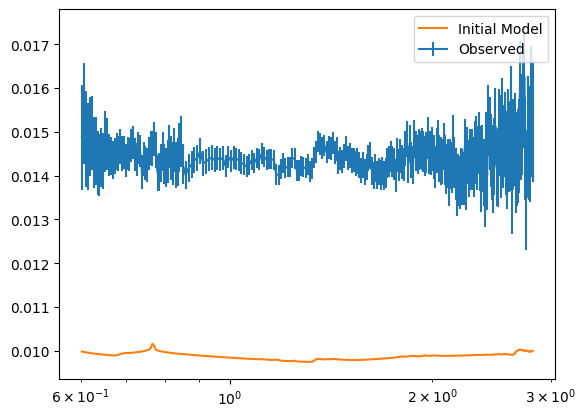

In [7]:
# now we make a binning and plot the spectrum:
obin = obs.create_binner()
plt.figure()
plt.errorbar(obs.wavelengthGrid,obs.spectrum, obs.errorBar,label='Observed')
plt.plot(obs.wavelengthGrid,obin.bin_model(tm.model(obs.wavenumberGrid))[1],label='Initial Model')
plt.xscale('log')
plt.legend()
plt.show()

In [8]:
from taurex.optimizer.nestle import NestleOptimizer
opt = NestleOptimizer(num_live_points=250)

opt.set_model(tm)
opt.set_observed(obs)

In [9]:
opt.enable_fit('planet_radius')
opt.enable_fit('T')
opt.enable_fit('H2O')
opt.enable_fit('CO2')
opt.enable_fit('CO')
opt.enable_fit('K')
opt.enable_fit('Na')
opt.set_boundary('T',[1000,2000])
opt.set_boundary('planet_radius',[0.8,2.1])
opt.set_boundary('H2O', [1e-10,1e-2])
opt.set_boundary('CO', [1e-10,1e-2])
opt.set_boundary('CO2', [1e-10,1e-2])
opt.set_boundary('Na', [1e-10,1e-2])
opt.set_boundary('K', [1e-10,1e-2])

In [10]:
solution = opt.fit()
taurex.log.disableLogging()

it=  3057 logz=1720.9350386977niter: 3058
ncall: 7590
nsamples: 3308
logz: 1721.224 +/-  0.195
h:  9.470


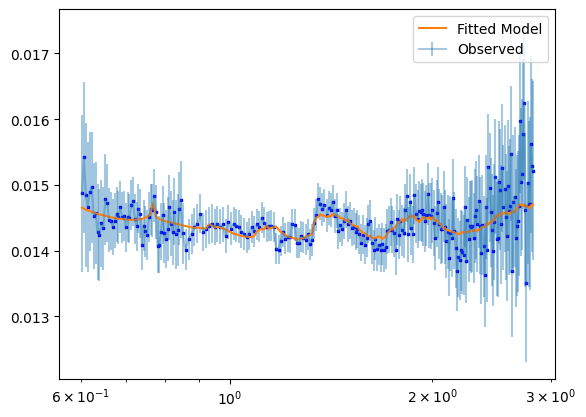

In [11]:
for solution,optimized_map,optimized_value,values in opt.get_solution():
    opt.update_model(optimized_map)
    plt.figure()
    plt.errorbar(obs.wavelengthGrid,obs.spectrum,obs.errorBar,label='Observed', alpha=0.4)
    plt.plot(obs.wavelengthGrid,obs.spectrum, marker='s', color='blue', markersize=2, linestyle='')
    plt.plot(obs.wavelengthGrid,obin.bin_model(tm.model(obs.wavenumberGrid))[1],label='Fitted Model')
    plt.xscale('log')
    plt.legend()
    plt.show()

## Retrieving parameters

In [12]:
res = opt.generate_solution()
fit_params = res['solution0']['fit_params']
traces = np.array([fit_params[key]['trace'] for key in fit_params.keys()])

We save the retrieved parameters in a csv file.

In [15]:
params = [[key,fit_params[key]['value'], fit_params[key]['sigma_m'], fit_params[key]['sigma_p']] for key in fit_params.keys()]
df = pd.DataFrame(params, columns=['param', 'value', 'sigma_m', 'sigma_p'], index=None)
df.to_csv('WASP-96b-fit.csv', index=False, sep='\t')

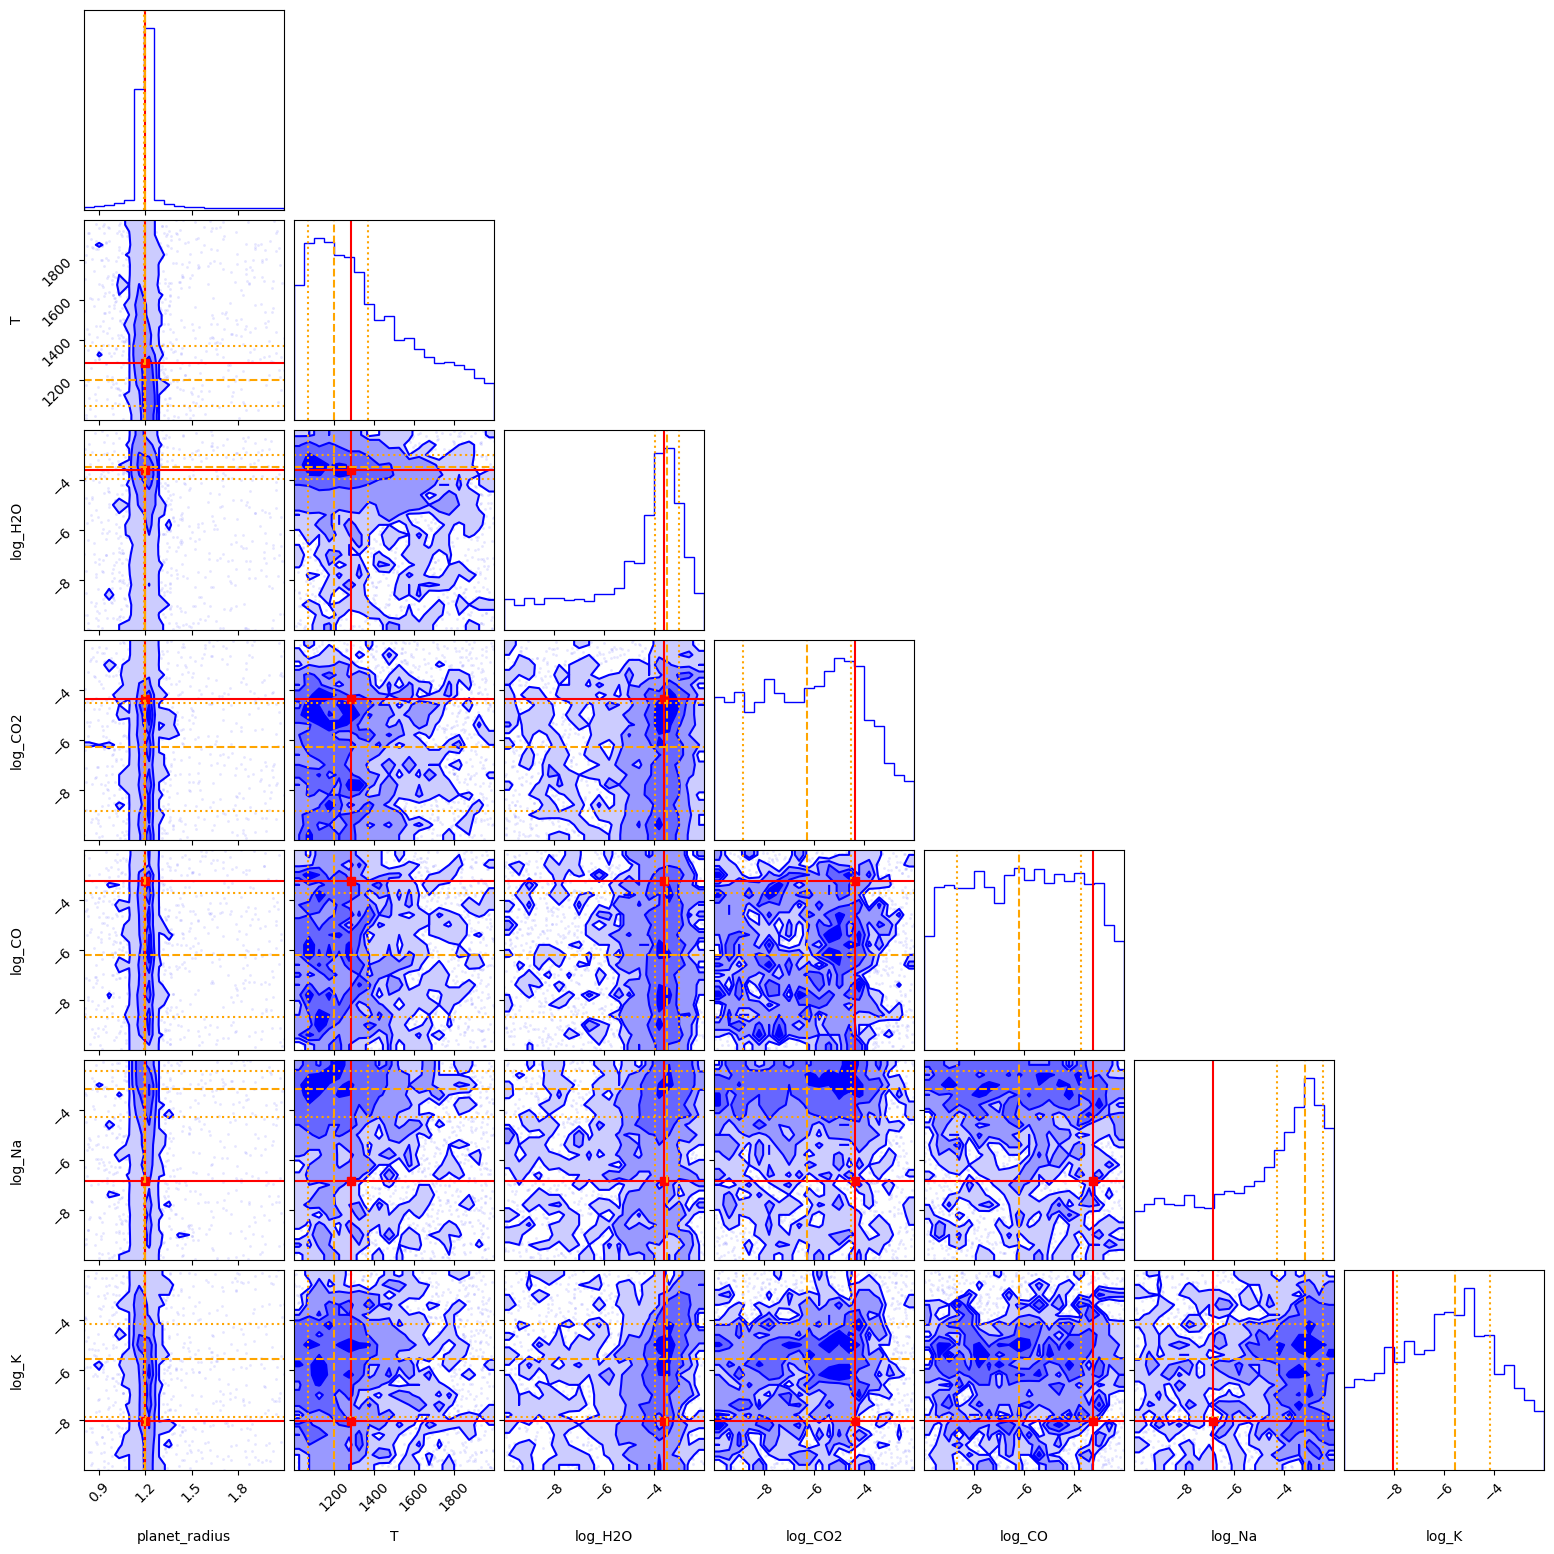

In [38]:
df = pd.read_csv('WASP-96b-fit.csv', sep='\t')
true_values =  [ 1.2, 1285, -3.59, -4.38,-3.25,-6.85, -8.04]

# Create the corner plot with colors and labels
fig = corner.corner(
    np.transpose(traces),  
    labels=df['param'], 
    color='blue',  
    plot_datapoints=True,  
    fill_contours=True,
    truths = true_values,
    truth_color = 'red',
)

corner.overplot_lines(fig, df['value'], linestyle='dashed', c='orange')
corner.overplot_lines(fig, df['value']+df['sigma_p'], linestyle='dotted', c='orange')
corner.overplot_lines(fig, df['value']-df['sigma_m'], linestyle='dotted', c='orange')

plt.show()